# Data cleaning


In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from Library.data_preprocessing_ML import clean_extract_domain, extract_domain_features, load_data, get_core_domain, preprocess_domains, compare_domains, create_abbreviation, get_domain_without_tld, check_words_in_url, check_abbreviation_in_url

# Load data and preprocess domains
dataset_query_path = 'Used_data_thesis/dataset_incl_query.csv'
search_results_paths = ['Used_data_thesis/search_results_DDG.csv']
merged_dataset = load_data(dataset_query_path, search_results_paths)

# Lowercase all URL columns before processing
url_columns = ['URL'] + [f'URL{i}' for i in range(1, 6)]
for col in url_columns:
    merged_dataset[col] = merged_dataset[col].str.lower()


# Initialize 'OfficialName_cleaned' and perform cleaning operations
merged_dataset['OfficialName_cleaned'] = merged_dataset['OfficialName'].str.lower()
merged_dataset['OfficialName'] = merged_dataset['OfficialName'].str.lower() # Lowercase the 'OfficialName' column
merged_dataset['OfficialName_cleaned'] = merged_dataset['OfficialName_cleaned'].str.replace(r"\[.*?\]", "", regex=True) # Remove text within brackets (including the brackets)
merged_dataset['OfficialName_cleaned'] = merged_dataset['OfficialName_cleaned'].str.replace(r"\(.*?\)", "", regex=True)
merged_dataset['OfficialName_cleaned'] = merged_dataset['OfficialName_cleaned'].str.replace('-', '', regex=True) # Remove hyphens from 'OfficialName'
merged_dataset['Abbreviation'] = merged_dataset.apply(
    lambda row: create_abbreviation(row['OfficialName_cleaned']) if pd.isna(row['Abbreviation']) else row['Abbreviation'],
    axis=1
    ) # Abbreviation creation if none is given


# Define the URL columns you are working with, e.g., 'URL', 'URL1', 'URL2', etc.
url_columns = ['URL'] + [f'URL{i}' for i in range(1, 6)]
url_columns_without_official =[f'URL{i}' for i in range(1, 6)]
# Preprocess the domains to extract the core domain
preprocess_domains(merged_dataset, url_columns)

# Extract and append domain features for each URL column with a suffix indicating the column
for col in url_columns:
    # Extract clean domain first
    merged_dataset[f'{col}_clean_domain'] = merged_dataset[col].apply(clean_extract_domain)

    # Extract domain features and add a prefix to each column name indicating the source URL column
    #domain_features_df = merged_dataset[f'{col}_clean_domain'].apply(lambda x: pd.Series(extract_domain_features(x)))
    #domain_features_df.rename(columns=lambda name: f"{name}_{col}", inplace=True)
    #merged_dataset = pd.concat([merged_dataset, domain_features_df], axis=1)

# Compare domains and add the comparison results to the DataFrame
comparison_domain_cols = [f'{col}_clean_domain' for col in url_columns if col != 'URL']
merged_dataset['domain_matches'] = merged_dataset.apply(
    lambda row: compare_domains(row, 'URL_clean_domain', comparison_domain_cols), axis=1
)

# Calculate the length of each 'URL(i)_domain'
for col in url_columns_without_official:
    domain_col = f'{col}_domain'
    if domain_col in merged_dataset.columns:
        # Apply the extraction of domain without TLD
        merged_dataset[f'{col}_core_domain'] = merged_dataset[domain_col].apply(get_domain_without_tld)
        # Calculate the length of the domain without TLD
        merged_dataset[f'{col}_domain_length'] = merged_dataset[f'{col}_core_domain'].str.len()

merged_dataset['Abbreviation'] = merged_dataset['Abbreviation'].str.lower() # Lowercase the 'OfficialName' column

for col in url_columns:
    if f'{col}_clean_domain' in merged_dataset.columns:
        # Check if any word from 'OfficialName' is in the URL
        merged_dataset[f'{col}_has_official_word'] = merged_dataset.apply(
            lambda row: check_words_in_url(row['OfficialName_cleaned'], row[col]), axis=1).astype(int)

        # Check if 'Abbreviation' is in the URL
        merged_dataset[f'{col}_has_abbreviation'] = merged_dataset.apply(
            lambda row: check_abbreviation_in_url(row['Abbreviation'], row[col]), axis=1).astype(int)

merged_dataset['OfficialName_cleaned'] = merged_dataset['OfficialName_cleaned'].str.replace(' ', '', regex=True) # Remove spaces
# Calculate the length of 'OfficialName_cleaned'
merged_dataset['OfficialName_cleaned_length'] = merged_dataset['OfficialName_cleaned'].str.len()

# Calculate the length of 'Abbreviation'
merged_dataset['Abbreviation_length'] = merged_dataset['Abbreviation'].str.len()
print(merged_dataset.columns)

Index(['EntityNumber', 'OfficialName', 'Abbreviation', 'ZipCode',
       'Municipality', 'Street', 'HouseNumber', 'URL', 'NaceCode',
       'SearchQuery', 'URL1', 'URL2', 'URL3', 'URL4', 'URL5',
       'OfficialName_cleaned', 'URL_domain', 'URL1_domain', 'URL2_domain',
       'URL3_domain', 'URL4_domain', 'URL5_domain', 'URL_clean_domain',
       'URL1_clean_domain', 'URL2_clean_domain', 'URL3_clean_domain',
       'URL4_clean_domain', 'URL5_clean_domain', 'domain_matches',
       'URL1_core_domain', 'URL1_domain_length', 'URL2_core_domain',
       'URL2_domain_length', 'URL3_core_domain', 'URL3_domain_length',
       'URL4_core_domain', 'URL4_domain_length', 'URL5_core_domain',
       'URL5_domain_length', 'URL_has_official_word', 'URL_has_abbreviation',
       'URL1_has_official_word', 'URL1_has_abbreviation',
       'URL2_has_official_word', 'URL2_has_abbreviation',
       'URL3_has_official_word', 'URL3_has_abbreviation',
       'URL4_has_official_word', 'URL4_has_abbreviation',
  

## Print statements for checking


In [3]:
# Display results and optionally save the updated dataset
print(merged_dataset[['OfficialName','Abbreviation','URL_domain','URL1_domain', 'URL1_clean_domain','OfficialName_cleaned_length','Abbreviation_length','URL', 'URL1','URL2','URL3','URL4','URL5', 'URL1_domain_length', 'URL1_has_official_word','URL1_has_abbreviation', 'domain_matches']].head(42))
print(merged_dataset.info())

                                         OfficialName Abbreviation  \
0                                                 igl          igl   
1                                            proximus            p   
2                           nationale bank van belgië         nbvb   
3   intergemeentelijk samenwerkingsverband van het...    interwaas   
4   rijksinstituut voor ziekte- en invaliditeitsve...        riziv   
5                  rijksdienst voor sociale zekerheid          rsz   
6    hulpkas voor ziekte- en invaliditeitsverzekering         hziv   
7               hulpkas voor werkloosheidsuitkeringen          hvw   
8                rijksdienst voor jaarlijkse vakantie          rjv   
9                               nationale arbeidsraad          nar   
10           federaal agentschap voor beroepsrisico's       fedris   
11                rijksdienst voor arbeidsvoorziening          rva   
12                            federale pensioendienst          fpd   
13                  

## Extract tld for deep cleaning domains

In [4]:
from Library.data_preprocessing_ML import extract_tlds

# List to collect all TLDs
all_tlds = set()

# Columns to check
url_columns = [f'URL{i}_clean_domain' for i in range(1, 6)]

# Loop through each column, apply the function, and update the set of TLDs
for col in url_columns:
    # Apply the extract_tlds function to the column
    current_tlds = merged_dataset[col].apply(extract_tlds)
    # Drop None values and update all_tlds set
    all_tlds.update(tld for tld in current_tlds if tld is not None)

# Print the unique TLDs found
print("Unique TLDs found in URL columns:", all_tlds)


Unique TLDs found in URL columns: {'.va', '.realtor', '.to', '.horse', '.no', '.fitness', '.nl', '.engineering', '.org', '.blog', '.one', '.beer', '.sg', '.aero', '.games', '.team', '.company', '.tv', '.sony', '.ro', '.art', '.id', '.fm', '.events', '.immo', '.men', '.dk', '.archi', '.academy', '.store', '.cat', '.cafe', '.link', '.hair', '.gov', '.bz', '.gent', '.nz', '.is', '.in', '.earth', '.care', '.info', '.so', '.et', '.agency', '.photo', '.energy', '.support', '.th', '.co', '.media', '.solar', '.tools', '.health', '.rest', '.monster', '.dev', '.international', '.coach', '.video', '.world', '.education', '.rs', '.diamonds', '.auction', '.green', '.finance', '.farm', '.space', '.site', '.clinic', '.today', '.coffee', '.at', '.pk', '.land', '.tz', '.mt', '.florist', '.cn', '.io', '.bar', '.ski', '.expert', '.ca', '.band', '.codes', '.ventures', '.museum', '.training', '.center', '.capital', '.cash', '.studio', '.digital', '.sport', '.travel', '.flowers', '.shoes', '.google', '.city

### Count missing values and replace with NaN

In [5]:
print(merged_dataset['OfficialName_cleaned'].isna().sum())
print(merged_dataset['Abbreviation'].isna().sum())

0
0


In [6]:
# Calculating the number of missing values in each column
missing_values_count = merged_dataset.isna().sum()

# Filtering and printing only the columns that have missing values
columns_with_na = missing_values_count[missing_values_count > 0]
print(columns_with_na)

# Calculating the percentage of missing values in each column
total_rows = len(merged_dataset)
missing_percentage = (merged_dataset.isna().sum() / total_rows) * 100

# Displaying the percentage of missing values for each column
print(missing_percentage)

NaceCode             1942
URL2                    2
URL3                    5
URL4                    6
URL5                   11
URL_domain             29
URL2_domain             3
URL3_domain             5
URL4_domain             8
URL5_domain            12
URL2_clean_domain       2
URL3_clean_domain       5
URL4_clean_domain       6
URL5_clean_domain      11
dtype: int64
EntityNumber                    0.000000
OfficialName                    0.000000
Abbreviation                    0.000000
ZipCode                         0.000000
Municipality                    0.000000
Street                          0.000000
HouseNumber                     0.000000
URL                             0.000000
NaceCode                       11.265155
SearchQuery                     0.000000
URL1                            0.000000
URL2                            0.011602
URL3                            0.029004
URL4                            0.034805
URL5                            0.063809
Official

In [7]:
merged_dataset = merged_dataset.fillna('NaN')

## Remove tld for better comparision between scraped and true URL

In [8]:
import re
import pandas as pd

# List of TLDs to exclude
tlds = all_tlds

# Compile regex pattern outside the function for efficiency
tld_pattern = r'\.(' + '|'.join([re.escape(tld.strip('.')) for tld in tlds]) + ')$'

def extract_until_tld(url):
    """Removes the last TLD from the URL if it matches the predefined list."""
    if pd.isna(url):
        return ""  # Handle NaN values
    # Replace the last occurrence of TLD
    url = re.sub(tld_pattern, "", url)
    return url


url_columns = [f'URL{i}_clean_domain' for i in range(1, 6)]


for col in url_columns:
    merged_dataset[f'{col}_before_tld'] = merged_dataset[col].apply(extract_until_tld)
print(merged_dataset[['URL1_clean_domain_before_tld','URL2_clean_domain_before_tld',
                      'URL3_clean_domain_before_tld','URL4_clean_domain_before_tld',
                      'URL5_clean_domain_before_tld']].head(10))


  URL1_clean_domain_before_tld URL2_clean_domain_before_tld  \
0                    iglimburg                   intergalva   
1                     proximus                     proximus   
2                          nbb                          nbb   
3           erfgoedcelwaasland                         vvsg   
4                   riziv.fgov                   riziv.fgov   
5                          rsz                          rsz   
6              caami-hziv.fgov              caami-hziv.fgov   
7               hvw-capac.fgov                 openingsuren   
8                     rjv.fgov                     rjv.fgov   
9                      cnt-nar                  werk.belgie   

  URL3_clean_domain_before_tld URL4_clean_domain_before_tld  \
0                     mapcarta               roamtechnology   
1                     proximus                     proximus   
2                    nbbmuseum                 openingsuren   
3                      govserv                   credi

# Feature engineering

## Calculate jaccard similarity, check subsequence, sequence match score and levenshtein distance

In [ ]:
%pip install pandarallel
%pip install python-Levenshtein

import pandas as pd
from difflib import SequenceMatcher
from pandarallel import pandarallel
import Levenshtein
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def jaccard_similarity(set1, set2):
    """ Calculate Jaccard similarity score. """
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def check_subsequence(company, url):
    """ Check if all characters in the company name can be found in sequence in the URL. """
    it = iter(url)
    return all(char in it for char in company)

def sequence_match_score(a, b):
    """ Use SequenceMatcher to find how similar two strings are. """
    return SequenceMatcher(None, a, b).ratio()

def levenshtein_distance_score(a, b):
    """ Calculate the Levenshtein distance between two strings. """
    return Levenshtein.distance(a, b)

def safe_set_conversion(text):
    """ Convert a text string to a set of characters, handling None safely. """
    if not text:
        return set()
    return set(text)

def cosine_similarity_score(a, b):
    """ Calculate the cosine similarity between two strings. """
    if not a or not b:
        return 0.0

    if len(a) < 3 or len(b) < 3:
        return 0.0  # Strings are too short for meaningful comparison

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    vectors = vectorizer.fit_transform([a, b])

    if vectors.shape[1] == 0:
        return 0.0  # No features extracted, possibly due to containing only stop words

    similarity = cosine_similarity(vectors)
    return similarity[0, 1]


def hamming_distance_score(a, b):
    """ Calculate the Hamming distance between two strings. """
    return sum(ch1 != ch2 for ch1, ch2 in zip(a, b))

def ngram_overlap_score(a, b):
    """ Calculate the n-gram overlap between two strings. """
    n = 3  # Adjust n-gram size as needed
    a_ngrams = set([a[i:i+n] for i in range(len(a)-n+1)])
    b_ngrams = set([b[i:i+n] for i in range(len(b)-n+1)])

    # Check for zero denominator
    if len(a_ngrams) == 0 or len(b_ngrams) == 0:
        return 0.0

    overlap = len(a_ngrams.intersection(b_ngrams))
    return overlap / min(len(a_ngrams), len(b_ngrams))


url_columns_without_tld = [f'URL{i}_clean_domain_before_tld' for i in range(1, 6)]

# Initialization
pandarallel.initialize(progress_bar=True)

# Parallel application of functions
for col in url_columns_without_tld:
    merged_dataset[f'{col}_official_jaccard'] = merged_dataset.parallel_apply(
        lambda row: jaccard_similarity(safe_set_conversion(row['OfficialName']), safe_set_conversion(row[col])), axis=1)

    merged_dataset[f'{col}_abbrev_jaccard'] = merged_dataset.parallel_apply(
        lambda row: jaccard_similarity(safe_set_conversion(row['Abbreviation']), safe_set_conversion(row[col])), axis=1)

    merged_dataset[f'{col}_official_is_subsequence'] = merged_dataset.parallel_apply(
        lambda row: check_subsequence(row['OfficialName'], row[col]), axis=1).astype(int)

    merged_dataset[f'{col}_abbrev_is_subsequence'] = merged_dataset.parallel_apply(
        lambda row: check_subsequence(row['Abbreviation'], row[col]), axis=1).astype(int)

    merged_dataset[f'{col}_official_seq_match'] = merged_dataset.parallel_apply(
        lambda row: sequence_match_score(row['OfficialName'], row[col]), axis=1)

    merged_dataset[f'{col}_abbrev_seq_match'] = merged_dataset.parallel_apply(
        lambda row: sequence_match_score(row['Abbreviation'], row[col]), axis=1)

    # Applying Levenshtein distance calculations
    merged_dataset[f'{col}_official_levenshtein'] = merged_dataset.parallel_apply(
        lambda row: levenshtein_distance_score(row['OfficialName'], row[col]), axis=1)

    merged_dataset[f'{col}_abbrev_levenshtein'] = merged_dataset.parallel_apply(
        lambda row: levenshtein_distance_score(row['Abbreviation'], row[col]), axis=1)

    merged_dataset[f'{col}_official_cosine_similarity'] = merged_dataset.parallel_apply(
        lambda row: cosine_similarity_score(row['OfficialName'], row[col]), axis=1)

    merged_dataset[f'{col}_abbrev_cosine_similarity'] = merged_dataset.parallel_apply(
        lambda row: cosine_similarity_score(row['Abbreviation'], row[col]), axis=1)

    merged_dataset[f'{col}_hamming_distance'] = merged_dataset.parallel_apply(
        lambda row: hamming_distance_score(row['OfficialName'], row[col]), axis=1)

    merged_dataset[f'{col}_ngram_overlap'] = merged_dataset.parallel_apply(
        lambda row: ngram_overlap_score(row['OfficialName'], row[col]), axis=1)

columns_to_display = [
    'EntityNumber', 'OfficialName', 'Abbreviation',
    'URL1_clean_domain_before_tld',
    'URL1_clean_domain_before_tld_official_jaccard', 'URL1_clean_domain_before_tld_abbrev_jaccard',
    'URL1_clean_domain_before_tld_official_is_subsequence', 'URL1_clean_domain_before_tld_abbrev_is_subsequence',
    'URL1_clean_domain_before_tld_official_seq_match', 'URL1_clean_domain_before_tld_abbrev_seq_match',
    'URL1_clean_domain_before_tld_official_levenshtein', 'URL1_clean_domain_before_tld_abbrev_levenshtein',
    'URL1_clean_domain_before_tld_official_cosine_similarity', 'URL1_clean_domain_before_tld_abbrev_cosine_similarity',
    'URL1_clean_domain_before_tld_hamming_distance','URL1_clean_domain_before_tld_ngram_overlap'
]
# Print the first few rows of these columns to inspect
print("Validation of DataFrame calculations:")
print(merged_dataset[columns_to_display].head(30))


contains_abbrev_subseq_count = merged_dataset['URL1_clean_domain_before_tld_abbrev_is_subsequence'].sum()
print(f"\nNumber of URLs where 'Abbreviation' is a subsequence: {contains_abbrev_subseq_count}")
contains_Official_subseq_count = merged_dataset['URL1_clean_domain_before_tld_official_is_subsequence'].sum()
print(f"Number of URLs where 'OfficialName' is a subsequence: {contains_Official_subseq_count}")

print("\nData Types and NaN Presence Check:")
print(merged_dataset[columns_to_display].info())


print("\nStatistical Summary of Computational Fields:")
print(merged_dataset[[col for col in merged_dataset.columns if 'jaccard' in col or 'seq_match' in col]].describe())

In [ ]:
print(merged_dataset.columns)

Index(['EntityNumber', 'OfficialName', 'Abbreviation', 'ZipCode',
       'Municipality', 'Street', 'HouseNumber', 'URL', 'NaceCode',
       'SearchQuery',
       ...
       'URL5_clean_domain_before_tld_official_is_subsequence',
       'URL5_clean_domain_before_tld_abbrev_is_subsequence',
       'URL5_clean_domain_before_tld_official_seq_match',
       'URL5_clean_domain_before_tld_abbrev_seq_match',
       'URL5_clean_domain_before_tld_official_levenshtein',
       'URL5_clean_domain_before_tld_abbrev_levenshtein',
       'URL5_clean_domain_before_tld_official_cosine_similarity',
       'URL5_clean_domain_before_tld_abbrev_cosine_similarity',
       'URL5_clean_domain_before_tld_hamming_distance',
       'URL5_clean_domain_before_tld_ngram_overlap'],
      dtype='object', length=118)


In [ ]:
print(len(merged_dataset))

17239


# Data preparation, stratified splitting, scaling, training, predictiong and evaluation of model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler

# Prepare the data
X = merged_dataset[['URL1_has_official_word', 'URL1_has_abbreviation',
                    'URL2_has_official_word', 'URL2_has_abbreviation',
                    'URL3_has_official_word', 'URL3_has_abbreviation',
                    'URL4_has_official_word', 'URL4_has_abbreviation',
                    'URL5_has_official_word', 'URL5_has_abbreviation',
                    'OfficialName_cleaned_length', 'Abbreviation_length',
                    'URL1_clean_domain_before_tld_official_jaccard',
                    'URL1_clean_domain_before_tld_abbrev_jaccard',
                    'URL1_clean_domain_before_tld_official_is_subsequence',
                    'URL1_clean_domain_before_tld_abbrev_is_subsequence',
                    'URL1_clean_domain_before_tld_official_seq_match',
                    'URL1_clean_domain_before_tld_abbrev_seq_match',
                    'URL1_clean_domain_before_tld_official_levenshtein',
                    'URL1_clean_domain_before_tld_abbrev_levenshtein',
                    'URL1_clean_domain_before_tld_official_cosine_similarity',
                    'URL1_clean_domain_before_tld_abbrev_cosine_similarity',
                    'URL1_clean_domain_before_tld_hamming_distance',
                    'URL1_clean_domain_before_tld_ngram_overlap',
                    'URL2_clean_domain_before_tld_official_jaccard',
                    'URL2_clean_domain_before_tld_abbrev_jaccard',
                    'URL2_clean_domain_before_tld_official_is_subsequence',
                    'URL2_clean_domain_before_tld_abbrev_is_subsequence',
                    'URL2_clean_domain_before_tld_official_seq_match',
                    'URL2_clean_domain_before_tld_abbrev_seq_match',
                    'URL2_clean_domain_before_tld_official_levenshtein',
                    'URL2_clean_domain_before_tld_abbrev_levenshtein',
                    'URL2_clean_domain_before_tld_official_cosine_similarity',
                    'URL2_clean_domain_before_tld_abbrev_cosine_similarity',
                    'URL2_clean_domain_before_tld_hamming_distance',
                    'URL2_clean_domain_before_tld_ngram_overlap',
                    'URL3_clean_domain_before_tld_official_jaccard',
                    'URL3_clean_domain_before_tld_abbrev_jaccard',
                    'URL3_clean_domain_before_tld_official_is_subsequence',
                    'URL3_clean_domain_before_tld_abbrev_is_subsequence',
                    'URL3_clean_domain_before_tld_official_seq_match',
                    'URL3_clean_domain_before_tld_abbrev_seq_match',
                    'URL3_clean_domain_before_tld_official_levenshtein',
                    'URL3_clean_domain_before_tld_abbrev_levenshtein',
                    'URL3_clean_domain_before_tld_official_cosine_similarity',
                    'URL3_clean_domain_before_tld_abbrev_cosine_similarity',
                    'URL3_clean_domain_before_tld_hamming_distance',
                    'URL3_clean_domain_before_tld_ngram_overlap',
                    'URL4_clean_domain_before_tld_official_jaccard',
                    'URL4_clean_domain_before_tld_abbrev_jaccard',
                    'URL4_clean_domain_before_tld_official_is_subsequence',
                    'URL4_clean_domain_before_tld_abbrev_is_subsequence',
                    'URL4_clean_domain_before_tld_official_seq_match',
                    'URL4_clean_domain_before_tld_abbrev_seq_match',
                    'URL4_clean_domain_before_tld_official_levenshtein',
                    'URL4_clean_domain_before_tld_abbrev_levenshtein',
                    'URL4_clean_domain_before_tld_official_cosine_similarity',
                    'URL4_clean_domain_before_tld_abbrev_cosine_similarity',
                    'URL4_clean_domain_before_tld_hamming_distance',
                    'URL4_clean_domain_before_tld_ngram_overlap',
                    'URL5_clean_domain_before_tld_official_jaccard',
                    'URL5_clean_domain_before_tld_abbrev_jaccard',
                    'URL5_clean_domain_before_tld_official_is_subsequence',
                    'URL5_clean_domain_before_tld_abbrev_is_subsequence',
                    'URL5_clean_domain_before_tld_official_seq_match',
                    'URL5_clean_domain_before_tld_abbrev_seq_match',
                    'URL5_clean_domain_before_tld_official_levenshtein',
                    'URL5_clean_domain_before_tld_abbrev_levenshtein',
                    'URL5_clean_domain_before_tld_official_cosine_similarity',
                    'URL5_clean_domain_before_tld_abbrev_cosine_similarity',
                    'URL5_clean_domain_before_tld_hamming_distance',
                    'URL5_clean_domain_before_tld_ngram_overlap']]

# Encode multilabel target
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(merged_dataset['domain_matches'])

# Split the data using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Verify Encoding, Verify Stratified Splitting, Check Data Scaling, Evaluate Model Outputs and Debug Total Support

In [ ]:
import numpy as np

# Check the shape of the encoded target variable
print("Shape of encoded targets:", y_encoded.shape)

# Check unique label counts
print("Number of unique labels:", len(mlb.classes_))

# Check a few rows to ensure encoding looks correct
print("Sample encoded labels:", y_encoded[:5])

# Check distribution of labels in the full dataset and in the split datasets
print("Label distribution in full dataset:", np.sum(y_encoded, axis=0))
print("Label distribution in training set:", np.sum(y_train, axis=0))
print("Label distribution in test set:", np.sum(y_test, axis=0))

# Check first few rows of scaled features
print("Sample scaled training features:", X_train_scaled[:5])
print("Sample scaled test features:", X_test_scaled[:5])

# Calculate total support manually
total_support = np.sum(y_test, axis=0)
print("Manual calculation of total support:", total_support)
print("Sum of total supports:", np.sum(total_support))

# Verify total support matches manual calculation
assert np.array_equal(total_support, np.sum(y_test, axis=0))


Shape of encoded targets: (17239, 6)
Number of unique labels: 6
Sample encoded labels: [[1 0 0 0 0 0]
 [0 1 0 0 1 0]
 [0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
Label distribution in full dataset: [7983 8315 3493 2012 1300 1099]
Label distribution in training set: [6386 6652 2795 1609 1040  880]
Label distribution in test set: [1597 1663  698  403  260  219]
Sample scaled training features: [[-1.83909457 -0.81595398  0.60418547 -0.79892123  0.66877966 -0.77908156
  -1.37322619 -0.76651458  0.80551364 -0.74778739  1.790146    5.95840491
  -1.22790816  0.02353346 -0.44388231 -0.96179097 -1.14196763 -0.054884
   2.1863606   2.19069591 -0.73362755  0.71694546 -0.24725559 -0.30084326
  -0.39716493  1.17421467 -0.28380509 -0.65744654 -0.82646739 -0.30314607
   1.94028809  2.21942929 -0.67312141 -0.19909747  1.12573434 -0.62447209
  -0.19986919  1.51706856 -0.22294204 -0.58798469 -0.92406962 -0.23396789
   1.90502171  2.22374037 -0.56087444 -0.17128607  1.09940519 -0.49526221
  -0.74925076 

### Logistic Regression


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
logistic_model = MultiOutputClassifier(LogisticRegression(max_iter=3000))
logistic_model.fit(X_train_scaled, y_train)



# Convert mlb.classes_ to a list of strings
target_names = [str(label) for label in mlb.classes_]

# Evaluate the models
print("Logistic Regression Model Evaluation:")
logistic_pred = logistic_model.predict(X_test_scaled)
print(classification_report(y_test, logistic_pred, target_names=target_names))



# Accuracy (note: this might not be very informative in multi-label settings)
print("Accuracy - Logistic Regression:", accuracy_score(y_test, logistic_pred))


# Hamming Loss
print("Hamming Loss - Logistic Regression:", hamming_loss(y_test, logistic_pred))


# Jaccard Score
# Calculate Jaccard Score for each label as an average
print("Jaccard Score - Logistic Regression:", jaccard_score(y_test, logistic_pred, average='samples'))


Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

          -1       0.86      0.83      0.84      1597
           1       0.85      0.92      0.88      1663
           2       0.78      0.84      0.81       698
           3       0.73      0.73      0.73       403
           4       0.69      0.71      0.70       260
           5       0.64      0.65      0.65       219

   micro avg       0.81      0.84      0.82      4840
   macro avg       0.76      0.78      0.77      4840
weighted avg       0.81      0.84      0.82      4840
 samples avg       0.82      0.84      0.82      4840

Accuracy - Logistic Regression: 0.7502900232018561
Hamming Loss - Logistic Regression: 0.08343000773395205
Jaccard Score - Logistic Regression: 0.8058343000773396


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Most important feature

Feature: URL1_clean_domain_before_tld_official_levenshtein, Coefficient: 0.7887423013061158
Feature: URL1_clean_domain_before_tld_official_seq_match, Coefficient: 0.7180100020729226
Feature: URL1_clean_domain_before_tld_official_cosine_similarity, Coefficient: 0.4933305418068426
Feature: OfficialName_cleaned_length, Coefficient: 0.4800665811865807
Feature: URL1_clean_domain_before_tld_ngram_overlap, Coefficient: 0.4270128948512328
Feature: URL1_clean_domain_before_tld_abbrev_seq_match, Coefficient: 0.3861899746364421
Feature: URL5_clean_domain_before_tld_official_levenshtein, Coefficient: 0.3345079693566972
Feature: URL1_clean_domain_before_tld_official_jaccard, Coefficient: 0.3063722027655793
Feature: URL3_clean_domain_before_tld_official_levenshtein, Coefficient: 0.29761904590597227
Feature: URL2_clean_domain_before_tld_official_cosine_similarity, Coefficient: 0.27714030153912406


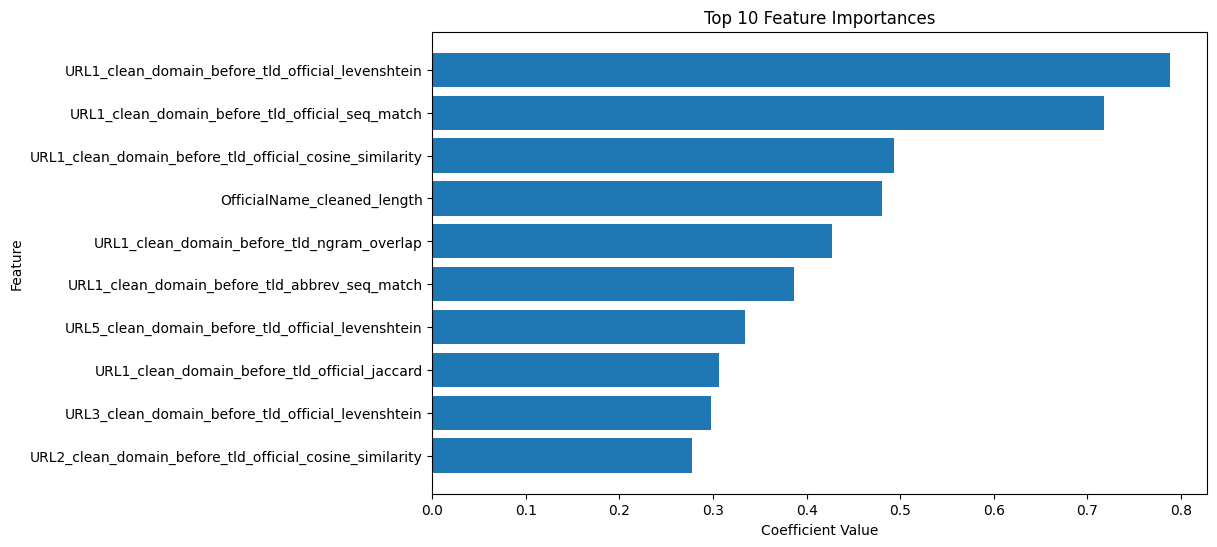

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the coefficients from each classifier in the MultiOutputClassifier
coefs = [estimator.coef_ for estimator in logistic_model.estimators_]

# Average the absolute coefficients across all classifiers (you could also choose max, min, etc.)
average_coefs = np.mean([np.abs(coef[0]) for coef in coefs], axis=0)

# Map feature names to average absolute coefficients
feature_names = X.columns
feature_coefficients_map = dict(zip(feature_names, average_coefs))

# Sort the features based on their average absolute coefficients
sorted_features = sorted(feature_coefficients_map.items(), key=lambda x: x[1], reverse=True)

# Limit to top 10 features
top_features = sorted_features[:10]

# Print the sorted list of top 10 features and their coefficients
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

# Extract features and coefficients for plotting the top 10
features = [x[0] for x in top_features]
coefficients = [x[1] for x in top_features]

# Creating a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.savefig('Most_imp_feat_LG')
plt.show()


### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score

# Train decision tree model using MultiOutputClassifier
tree_model = MultiOutputClassifier(DecisionTreeClassifier())
tree_model.fit(X_train_scaled, y_train)

print("\nDecision Tree Model Evaluation:")
tree_pred = tree_model.predict(X_test_scaled)

print(classification_report(y_test, tree_pred, target_names=target_names))

print("Accuracy - Decision Tree:", accuracy_score(y_test, tree_pred))

print("Hamming Loss - Decision Tree:", hamming_loss(y_test, tree_pred))

print("Jaccard Score - Decision Tree:", jaccard_score(y_test, tree_pred, average='samples'))


Decision Tree Model Evaluation:
              precision    recall  f1-score   support

          -1       0.75      0.77      0.76      1597
           1       0.81      0.79      0.80      1663
           2       0.72      0.72      0.72       698
           3       0.66      0.68      0.67       403
           4       0.62      0.64      0.63       260
           5       0.60      0.63      0.61       219

   micro avg       0.74      0.75      0.75      4840
   macro avg       0.69      0.71      0.70      4840
weighted avg       0.74      0.75      0.75      4840
 samples avg       0.72      0.76      0.72      4840

Accuracy - Decision Tree: 0.5774361948955916
Hamming Loss - Decision Tree: 0.11924787316318639
Jaccard Score - Decision Tree: 0.6885634184068058


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Feature importance

Feature: URL1_clean_domain_before_tld_ngram_overlap, Importance: 0.18895140503477845
Feature: URL2_clean_domain_before_tld_ngram_overlap, Importance: 0.08595431328736879
Feature: URL3_clean_domain_before_tld_ngram_overlap, Importance: 0.0758326427435098
Feature: URL4_clean_domain_before_tld_ngram_overlap, Importance: 0.07127402809494103
Feature: URL5_clean_domain_before_tld_ngram_overlap, Importance: 0.06235732459291208
Feature: URL1_clean_domain_before_tld_official_seq_match, Importance: 0.035675857788962755
Feature: URL5_clean_domain_before_tld_official_seq_match, Importance: 0.025809273937722865
Feature: URL1_clean_domain_before_tld_abbrev_seq_match, Importance: 0.025270074536497586
Feature: URL2_clean_domain_before_tld_official_seq_match, Importance: 0.022981924038544172
Feature: URL3_clean_domain_before_tld_official_seq_match, Importance: 0.02049466035294561


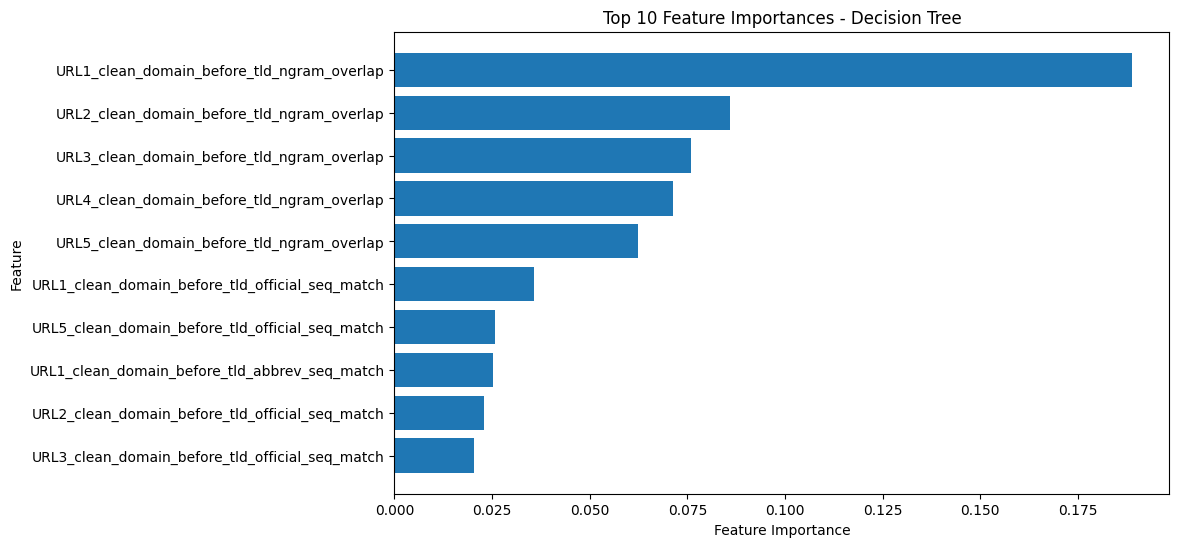

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the feature importances from each classifier in the MultiOutputClassifier
importances = [estimator.feature_importances_ for estimator in tree_model.estimators_]

# Average the feature importances across all classifiers
average_importances = np.mean(importances, axis=0)

# Map feature names to average importances
feature_names = X.columns
feature_importance_map = dict(zip(feature_names, average_importances))

# Sort the features based on their average importances
sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Limit to top 10 features
top_features = sorted_features[:10]

# Print the sorted list of top 10 features and their importances
for feature, importance in top_features:
    print(f"Feature: {feature}, Importance: {importance}")

# Extract features and importances for plotting the top 10
features = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

# Creating a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Decision Tree')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.savefig('Most_imp_feat_DT')
plt.show()


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score

# Train Random Forest model using MultiOutputClassifier
rf_model = MultiOutputClassifier(RandomForestClassifier())
rf_model.fit(X_train_scaled, y_train)

# Evaluate Random Forest model
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest Model Evaluation:")
print(classification_report(y_test, rf_pred, target_names=target_names))

# Accuracy (note: this might not be very informative in multi-label settings)
print("Accuracy - Random Forest:", accuracy_score(y_test, rf_pred))

# Hamming Loss
print("Hamming Loss - Random Forest:", hamming_loss(y_test, rf_pred))

# Jaccard Score
# Calculate Jaccard Score for each label as an average
print("Jaccard Score - Random Forest:", jaccard_score(y_test, rf_pred, average='samples'))

Random Forest Model Evaluation:
              precision    recall  f1-score   support

          -1       0.89      0.80      0.85      1597
           1       0.84      0.94      0.89      1663
           2       0.81      0.85      0.83       698
           3       0.77      0.74      0.75       403
           4       0.79      0.71      0.75       260
           5       0.72      0.63      0.67       219

   micro avg       0.84      0.84      0.84      4840
   macro avg       0.80      0.78      0.79      4840
weighted avg       0.84      0.84      0.84      4840
 samples avg       0.83      0.83      0.83      4840

Accuracy - Random Forest: 0.787122969837587
Hamming Loss - Random Forest: 0.07555104408352668
Jaccard Score - Random Forest: 0.818527648878577


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Feature importance

Feature: URL1_clean_domain_before_tld_official_seq_match, Importance: 0.04868844106851588
Feature: URL1_clean_domain_before_tld_ngram_overlap, Importance: 0.04780186301783767
Feature: URL1_clean_domain_before_tld_official_cosine_similarity, Importance: 0.04675093226716915
Feature: URL1_clean_domain_before_tld_official_jaccard, Importance: 0.0336445800600347
Feature: URL4_clean_domain_before_tld_official_seq_match, Importance: 0.028127304951841462
Feature: URL2_clean_domain_before_tld_official_seq_match, Importance: 0.02801794152030253
Feature: URL2_clean_domain_before_tld_ngram_overlap, Importance: 0.02735477975853493
Feature: URL1_clean_domain_before_tld_abbrev_seq_match, Importance: 0.025679415880817475
Feature: URL2_clean_domain_before_tld_official_cosine_similarity, Importance: 0.025676565330259842
Feature: URL2_clean_domain_before_tld_official_jaccard, Importance: 0.025237514038045084


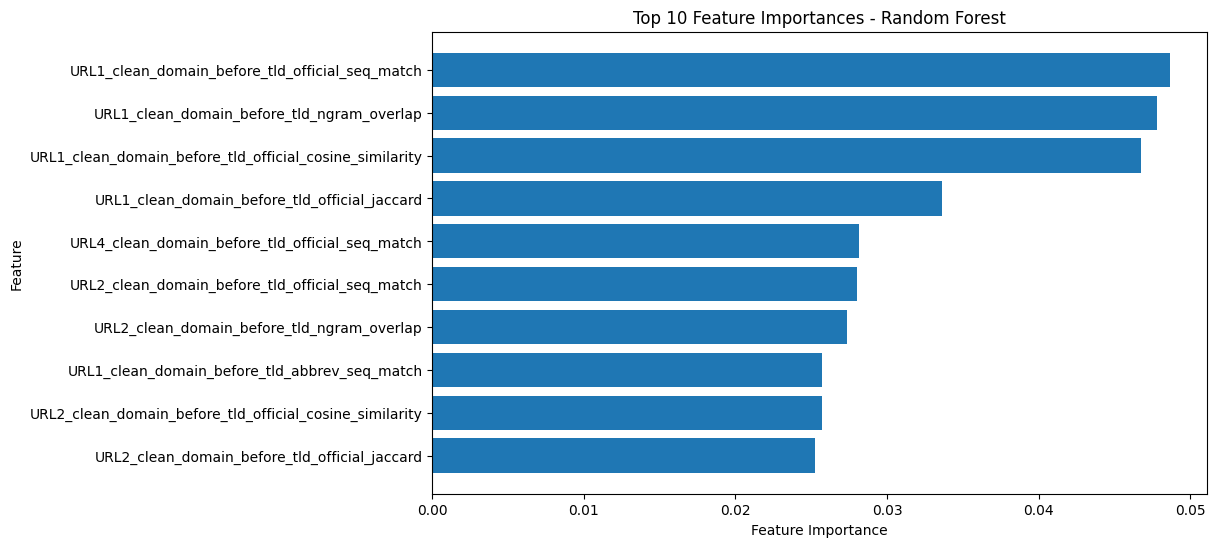

In [ ]:
# Retrieve the feature importances from each classifier in the MultiOutputClassifier
importances = [estimator.feature_importances_ for estimator in rf_model.estimators_]

# Average the feature importances across all classifiers
average_importances = np.mean(importances, axis=0)

# Map feature names to average importances
feature_names = X.columns
feature_importance_map = dict(zip(feature_names, average_importances))

# Sort the features based on their average importances
sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Limit to top 10 features
top_features = sorted_features[:10]

# Print the sorted list of top 10 features and their importances
for feature, importance in top_features:
    print(f"Feature: {feature}, Importance: {importance}")

# Extract features and importances for plotting the top 10
features = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

# Creating a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Random Forest')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.savefig('Most_imp_feat_RF')
plt.show()


### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score

# Train Gradient Boosting model using MultiOutputClassifier
gb_model = MultiOutputClassifier(GradientBoostingClassifier())
gb_model.fit(X_train_scaled, y_train)

# Evaluate Gradient Boosting model
gb_pred = gb_model.predict(X_test_scaled)
print("\nGradient Boosting Model Evaluation:")
print(classification_report(y_test, gb_pred, target_names=target_names))

# Accuracy (note: this might not be very informative in multi-label settings)
print("Accuracy - Gradient Boosting Classifier:", accuracy_score(y_test, gb_pred))

# Hamming Loss
print("Hamming Loss - Gradient Boosting Classifier:", hamming_loss(y_test, gb_pred))

# Jaccard Score
# Calculate Jaccard Score for each label as an average
print("Jaccard Score - Gradient Boosting Classifier:", jaccard_score(y_test, gb_pred, average='samples'))


Gradient Boosting Model Evaluation:
              precision    recall  f1-score   support

          -1       0.88      0.81      0.84      1597
           1       0.84      0.94      0.89      1663
           2       0.80      0.88      0.84       698
           3       0.77      0.78      0.78       403
           4       0.73      0.71      0.72       260
           5       0.71      0.68      0.70       219

   micro avg       0.83      0.85      0.84      4840
   macro avg       0.79      0.80      0.79      4840
weighted avg       0.83      0.85      0.84      4840
 samples avg       0.83      0.84      0.83      4840

Accuracy - Gradient Boosting Classifier: 0.7821925754060325
Hamming Loss - Gradient Boosting Classifier: 0.07671113689095127
Jaccard Score - Gradient Boosting Classifier: 0.819436388244393


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Feature importance

Feature: URL1_clean_domain_before_tld_ngram_overlap, Importance: 0.22331361163739927
Feature: URL2_clean_domain_before_tld_ngram_overlap, Importance: 0.11878570526281194
Feature: URL3_clean_domain_before_tld_ngram_overlap, Importance: 0.09781081584464925
Feature: URL4_clean_domain_before_tld_ngram_overlap, Importance: 0.09203426001642774
Feature: URL1_clean_domain_before_tld_official_cosine_similarity, Importance: 0.06749859003587483
Feature: URL5_clean_domain_before_tld_ngram_overlap, Importance: 0.0538111296502975
Feature: URL5_clean_domain_before_tld_official_cosine_similarity, Importance: 0.04699295302200254
Feature: URL1_clean_domain_before_tld_abbrev_seq_match, Importance: 0.03186512292662593
Feature: URL1_clean_domain_before_tld_official_seq_match, Importance: 0.030568743500938394
Feature: URL4_clean_domain_before_tld_official_seq_match, Importance: 0.020032277745159657


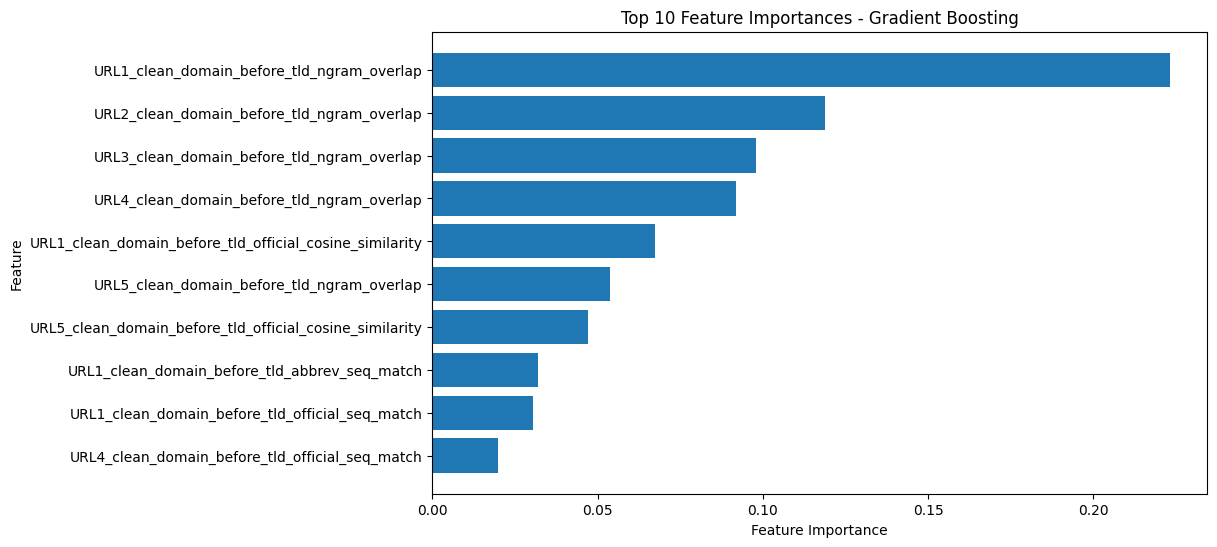

In [ ]:
# Retrieve the feature importances from each classifier in the MultiOutputClassifier
importances = [estimator.feature_importances_ for estimator in gb_model.estimators_]

# Average the feature importances across all classifiers
average_importances = np.mean(importances, axis=0)

# Map feature names to average importances
feature_names = X.columns
feature_importance_map = dict(zip(feature_names, average_importances))

# Sort the features based on their average importances
sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Limit to top 10 features
top_features = sorted_features[:10]

# Print the sorted list of top 10 features and their importances
for feature, importance in top_features:
    print(f"Feature: {feature}, Importance: {importance}")

# Extract features and importances for plotting the top 10
features = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

# Creating a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Gradient Boosting')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.savefig('Most_imp_feat_GB')
plt.show()


### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score

# Train SVM model using MultiOutputClassifier
svm_model = MultiOutputClassifier(SVC())
svm_model.fit(X_train_scaled, y_train)

# Evaluate SVM model
svm_pred = svm_model.predict(X_test_scaled)
print("\nSVM Model Evaluation:")
print(classification_report(y_test, svm_pred, target_names=target_names))

# Accuracy (note: this might not be very informative in multi-label settings)
print("Accuracy - Support Vector Machine (SVM):", accuracy_score(y_test, svm_pred))

# Hamming Loss
print("Hamming Loss - Support Vector Machine (SVM):", hamming_loss(y_test, svm_pred))

# Jaccard Score
# Calculate Jaccard Score for each label as an average
print("Jaccard Score - Support Vector Machine (SVM):", jaccard_score(y_test, svm_pred, average='samples'))


SVM Model Evaluation:
              precision    recall  f1-score   support

          -1       0.89      0.80      0.84      1597
           1       0.84      0.94      0.89      1663
           2       0.79      0.87      0.83       698
           3       0.74      0.75      0.74       403
           4       0.75      0.70      0.73       260
           5       0.70      0.66      0.68       219

   micro avg       0.83      0.84      0.84      4840
   macro avg       0.78      0.79      0.78      4840
weighted avg       0.83      0.84      0.83      4840
 samples avg       0.83      0.84      0.83      4840

Accuracy - Support Vector Machine (SVM): 0.7848027842227379
Hamming Loss - Support Vector Machine (SVM): 0.07758120649651973
Jaccard Score - Support Vector Machine (SVM): 0.8187983372003094


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score

# Train Neural Network model using MultiOutputClassifier
nn_model = MultiOutputClassifier(MLPClassifier())
nn_model.fit(X_train_scaled, y_train)

# Evaluate Neural Network model
nn_pred = nn_model.predict(X_test_scaled)
print("\nNeural Network Model Evaluation:")
print(classification_report(y_test, nn_pred, target_names=target_names))

# Accuracy (note: this might not be very informative in multi-label settings)
print("Accuracy - Neural Network:", accuracy_score(y_test, nn_pred))

# Hamming Loss
print("Hamming Loss - Neural Network:", hamming_loss(y_test, nn_pred))

# Jaccard Score
# Calculate Jaccard Score for each label as an average
print("Jaccard Score - Neural Network:", jaccard_score(y_test, nn_pred, average='samples'))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro


Neural Network Model Evaluation:
              precision    recall  f1-score   support

          -1       0.83      0.80      0.81      1597
           1       0.84      0.87      0.85      1663
           2       0.78      0.76      0.77       698
           3       0.72      0.75      0.73       403
           4       0.68      0.67      0.67       260
           5       0.65      0.62      0.63       219

   micro avg       0.80      0.80      0.80      4840
   macro avg       0.75      0.74      0.75      4840
weighted avg       0.80      0.80      0.80      4840
 samples avg       0.79      0.80      0.79      4840

Accuracy - Neural Network: 0.6919953596287703
Hamming Loss - Neural Network: 0.09362915699922661
Jaccard Score - Neural Network: 0.7648056844547563


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Shap for explaining model predictions

  0%|          | 0/100 [00:00<?, ?it/s]

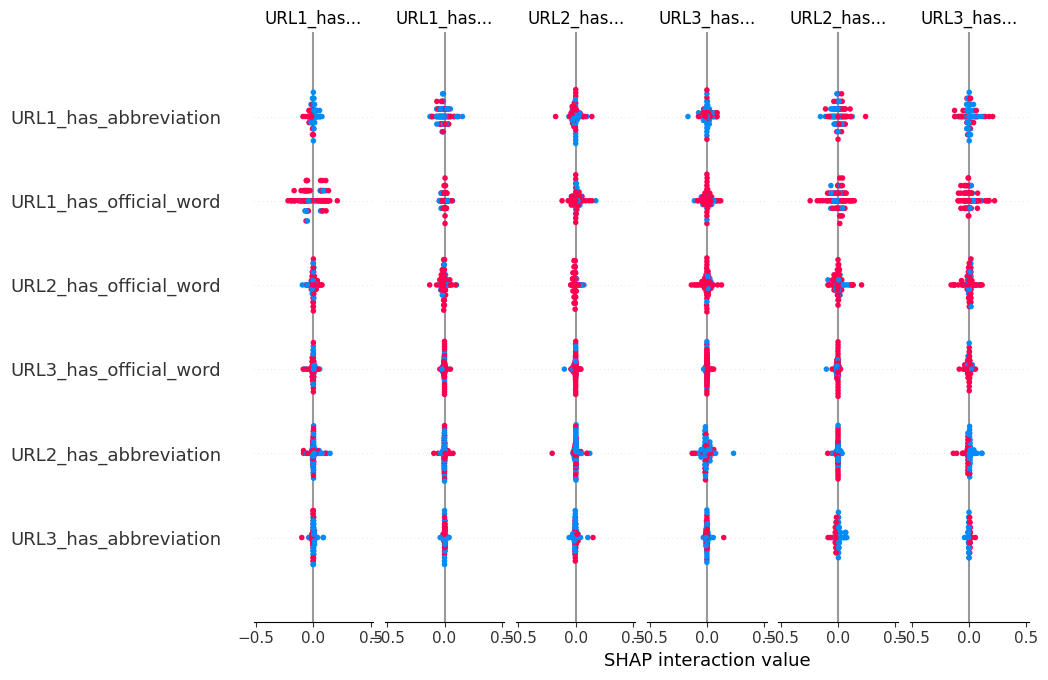

In [ ]:
%pip install shap
import shap

# Create a SHAP explainer and calculate SHAP values
explainer = shap.KernelExplainer(nn_model.predict, shap.sample(X_train_scaled, 100))  # using 100 samples for approximation
shap_values = explainer.shap_values(shap.sample(X_test_scaled, 100))

# Plot the summary of SHAP values
shap.summary_plot(shap_values, shap.sample(X_test_scaled, 100), feature_names=X.columns)
plt.savefig('shap_summary_plot.png')
plt.close()

### K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score

# Train KNN model using MultiOutputClassifier
knn_model = MultiOutputClassifier(KNeighborsClassifier())
knn_model.fit(X_train_scaled, y_train)

# Evaluate KNN model
knn_pred = knn_model.predict(X_test_scaled)
print("\nK-Nearest Neighbors Model Evaluation:")
print(classification_report(y_test, knn_pred, target_names=target_names))

# Accuracy (note: this might not be very informative in multi-label settings)
print("Accuracy - K-Nearest Neighbors:", accuracy_score(y_test, knn_pred))

# Hamming Loss
print("Hamming Loss - K-Nearest Neighbors:", hamming_loss(y_test, knn_pred))

# Jaccard Score
# Calculate Jaccard Score for each label as an average
print("Jaccard Score - K-Nearest Neighbors:", jaccard_score(y_test, knn_pred, average='samples'))


K-Nearest Neighbors Model Evaluation:
              precision    recall  f1-score   support

          -1       0.86      0.80      0.83      1597
           1       0.83      0.92      0.87      1663
           2       0.75      0.83      0.79       698
           3       0.70      0.74      0.72       403
           4       0.68      0.69      0.68       260
           5       0.61      0.66      0.64       219

   micro avg       0.80      0.83      0.81      4840
   macro avg       0.74      0.77      0.75      4840
weighted avg       0.80      0.83      0.81      4840
 samples avg       0.81      0.82      0.81      4840

Accuracy - K-Nearest Neighbors: 0.7505800464037123
Hamming Loss - K-Nearest Neighbors: 0.08927880897138438
Jaccard Score - K-Nearest Neighbors: 0.7980906805877803


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Manual Visualization

In [ ]:
import pandas as pd

# Convert logistic predictions into DataFrame
pred_df = pd.DataFrame(rf_pred, columns=[f'Label_{i+1}' for i in range(rf_pred.shape[1])], index=X_test.index)

# Adjusted function to handle non-string label types
def extract_predicted_labels(row):
    labels = []
    for i, value in enumerate(row):
        if value == 1:
            labels.append(str(mlb.classes_[i]))  # Convert label to string
    return ', '.join(labels) if labels else 'No Label Predicted'

# Apply function to rows to create a 'PredictedLabel' column
pred_df['PredictedLabel'] = pred_df.apply(extract_predicted_labels, axis=1)

# Join this with the entity number from the original dataset

final_df = merged_dataset.loc[pred_df.index, ['EntityNumber']].join(pred_df[['PredictedLabel']])

# Here is the final DataFrame
print(final_df.head(50))

# Optional: Save this DataFrame to CSV
# final_df.to_csv('predictions_with_entity_number.csv')


       EntityNumber      PredictedLabel
16311  0892.342.491                  -1
7366   0737.675.991                   1
12838  0793.579.665                  -1
16211  0889.390.327                  -1
3448   0479.207.120                  -1
4359   0627.961.865                   1
13856  0804.906.196  No Label Predicted
4562   0640.879.493                  -1
7859   0741.841.251                  -1
4361   0627.970.179                   1
14049  0808.712.853                   1
7881   0741.986.553                2, 4
2424   0459.399.819                1, 2
6310   0726.883.851                1, 5
12820  0793.420.507                  -1
12577  0790.170.314                  -1
11206  0775.303.677                  -1
7787   0740.994.579                   1
16983  1004.105.495                  -1
5689   0689.580.225                  -1
10021  0763.427.414                  -1
5415   0676.578.067                   1
13757  0803.883.144             1, 2, 3
6737   0731.624.082                  -1


# Use predictions to return correct URL

## Wrongly appointed labels

In [ ]:
import pandas as pd
import numpy as np

# Convert predictions and actuals to readable label lists
predicted_labels = ['; '.join(str(label) for label in labels) if labels else 'No Labels Predicted' for labels in mlb.inverse_transform(logistic_pred)]
actual_labels = ['; '.join(str(label) for label in labels) if labels else 'No Labels Predicted' for labels in mlb.inverse_transform(y_test)]

# Step 1: Calculate Incorrect Predictions
# Create a boolean array where True indicates a mismatch between prediction and actual label
incorrect_predictions_mask = logistic_pred != y_test

# Step 2: Count Incorrect Predictions
# Sum the True values in incorrect_predictions_mask for each sample
incorrect_counts = incorrect_predictions_mask.sum(axis=1)

# Print total number of incorrect label predictions across all samples
total_incorrect_labels = incorrect_counts.sum()
print("Total incorrect label predictions:", total_incorrect_labels)

# Step 3: Create a DataFrame for incorrect predictions
# Include only those samples that have one or more incorrectly predicted labels
samples_with_incorrect_predictions = incorrect_counts > 0

# Convert the lists to Series for proper indexing
predicted_labels_series = pd.Series(predicted_labels, index=X_test.index)
actual_labels_series = pd.Series(actual_labels, index=X_test.index)

# Extract the corresponding rows from X_test

incorrect_predictions_df = pd.DataFrame({
    'EntityNumber': merged_dataset.loc[X_test.index[samples_with_incorrect_predictions], 'EntityNumber'],
    'IncorrectCount': incorrect_counts[samples_with_incorrect_predictions],
    'PredictedLabels': predicted_labels_series[samples_with_incorrect_predictions],
    'ActualLabels': actual_labels_series[samples_with_incorrect_predictions]
})

# Print or explore the DataFrame
print(incorrect_predictions_df.head(20))

# Optional: Save this DataFrame to a CSV file
# incorrect_predictions_df.to_csv('incorrect_predictions.csv')



Total incorrect label predictions: 1726
       EntityNumber  IncorrectCount      PredictedLabels ActualLabels
16311  0892.342.491               3                   -1         1; 5
13856  0804.906.196               1                -1; 3           -1
4361   0627.970.179               2                    1           -1
7881   0741.986.553               2                -1; 2         2; 4
6310   0726.883.851               3                 1; 5           -1
12577  0790.170.314               2                   -1            1
16983  1004.105.495               1                -1; 3            3
5415   0676.578.067               2                    1           -1
10221  0765.224.288               1  No Labels Predicted           -1
7928   0742.727.614               1                -1; 2            2
11936  0782.811.774               1                 1; 5            1
12383  0787.585.362               2                   -1            1
4884   0654.880.058               2               

# Hyperparameter tuning

### Logistic Regression

In [ ]:
%pip install iterative-stratification

import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Parameters for GridSearchCV
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__penalty': ['l2'],  # Removed l1 as it's not compatible with 'liblinear' for 'ovr'
    'estimator__solver': ['liblinear']
}

# Create the logistic regression model within a MultiOutputClassifier
logistic_model = MultiOutputClassifier(LogisticRegression(max_iter=3000))

# Setup stratified cross-validation folds for multi-label data
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scorer, example using f1_score with micro averaging
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Initialize GridSearchCV with multi-label stratified folds and f1_micro as the scoring function
grid_search = GridSearchCV(logistic_model, param_grid, scoring=f1_macro_scorer, cv=mskf, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best estimator and score found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

df_new_results = pd.DataFrame([grid_search.best_params_], index=[0])
df_new_results['model'] = 'Logistic Regression'

# Check if the results CSV file exists
if os.path.exists('hyperparameter_tuning_results.csv'):
    existing_results = pd.read_csv('hyperparameter_tuning_results.csv')
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv('hyperparameter_tuning_results.csv', index=False)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'estimator__C': 1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
Best cross-validation score: 0.77


### Decision Tree

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GridSearchCV
import os

# Parameters for GridSearchCV
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Setup stratified cross-validation folds for multi-label data
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Use f1_score with micro averaging as the scoring function
f1_macro_scorer = make_scorer(f1_score, average='macro')

# GridSearchCV setup
grid_search_dt = GridSearchCV(decision_tree_model, param_grid_dt, cv=mskf, scoring=f1_macro_scorer, verbose=1)
grid_search_dt.fit(X_train, y_train)

# Evaluate and print best parameters and model performance
print("Best parameters:", grid_search_dt.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_dt.best_score_))

# Create a DataFrame from the best parameters and add a column specifying the model
df_new_results = pd.DataFrame([grid_search_dt.best_params_], index=[0])
df_new_results['model'] = 'Decision Tree'

# Check if the results CSV file exists
if os.path.exists('hyperparameter_tuning_results.csv'):
    existing_results = pd.read_csv('hyperparameter_tuning_results.csv')
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv('hyperparameter_tuning_results.csv', index=False)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best cross-validation score: 0.73


### Gradient Booster Classifier

In [ ]:
import pandas as pd
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Parameters for GridSearchCV
param_grid_gb = {
    'estimator__n_estimators': [100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 8]
}

# Setup stratified cross-validation folds for multi-label data
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gradient boosting model wrapped in MultiOutputClassifier
gradient_boosting_model = MultiOutputClassifier(GradientBoostingClassifier(random_state=42))

# Use f1_score with micro averaging as the scoring function
f1_macro_scorer = make_scorer(f1_score, average='macro')

# GridSearchCV setup
grid_search_gb = GridSearchCV(gradient_boosting_model, param_grid_gb, cv=mskf, scoring=f1_macro_scorer, verbose=1)
grid_search_gb.fit(X_train, y_train)

# Evaluate and print best parameters and model performance
print("Best parameters:", grid_search_gb.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_gb.best_score_))

# Create a DataFrame from the best parameters and add a column specifying the model
df_new_results = pd.DataFrame([grid_search_gb.best_params_], index=[0])
df_new_results['model'] = 'Gradient Boosting'

# Check if the results CSV file exists
if os.path.exists('hyperparameter_tuning_results.csv'):
    existing_results = pd.read_csv('hyperparameter_tuning_results.csv')
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv('hyperparameter_tuning_results.csv', index=False)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 100}
Best cross-validation score: 0.79


### Random Forest

In [ ]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Parameters for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Setup stratified cross-validation folds for multi-label data
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random forest model wrapped in MultiOutputClassifier (if needed, otherwise just RandomForestClassifier)
random_forest_model = RandomForestClassifier(random_state=42)

# Use f1_score with micro averaging as the scoring function
f1_macro_scorer = make_scorer(f1_score, average='macro')

# GridSearchCV setup
grid_search_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=mskf, scoring=f1_macro_scorer, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Evaluate and print best parameters and model performance
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

# Create a DataFrame from the best parameters and add a column specifying the model
df_new_results = pd.DataFrame([grid_search_rf.best_params_], index=[0])
df_new_results['model'] = 'Random Forest'

# Check if the results CSV file exists
if os.path.exists('hyperparameter_tuning_results.csv'):
    existing_results = pd.read_csv('hyperparameter_tuning_results.csv')
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv('hyperparameter_tuning_results.csv', index=False)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 200}
Best cross-validation score: 0.76


### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Initialize Multilabel Stratified K-Fold
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the parameter grid for SVM
param_grid_svm = {
    'estimator__svc__C': [0.1, 1, 10],
    'estimator__svc__gamma': ['scale', 'auto'],
    'estimator__svc__kernel': ['rbf', 'linear']
}

# Create a pipeline that first scales the data then applies SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

# Wrap the pipeline and SVM in OneVsRestClassifier
ovr_pipeline = OneVsRestClassifier(pipeline_svm)

# Define the scoring function
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Setup GridSearchCV
grid_search_svm = GridSearchCV(ovr_pipeline, param_grid_svm, cv=mskf, scoring=f1_macro_scorer, verbose=1)
grid_search_svm.fit(X_train, y_train)

# Output the results
print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_svm.best_score_))

# Create a DataFrame from the best parameters and add a column specifying the model
df_new_results = pd.DataFrame([grid_search_svm.best_params_], index=[0])
df_new_results['model'] = 'SVM'

# Check if the results CSV file exists
if os.path.exists('hyperparameter_tuning_results.csv'):
    existing_results = pd.read_csv('hyperparameter_tuning_results.csv')
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv('hyperparameter_tuning_results.csv', index=False)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'estimator__svc__C': 1, 'estimator__svc__gamma': 'scale', 'estimator__svc__kernel': 'rbf'}
Best cross-validation score: 0.78


### Neural Networks

In [ ]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred_binary = tf.where(y_pred >= 0.5, 1, 0)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred_binary, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_binary, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

In [ ]:
%pip install keras keras-tuner
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch
import pandas as pd
import os

def build_model(hp):
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                  loss='binary_crossentropy',
                  metrics=[f1_score])
    return model

# Create a tuner object
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='keras_tuning'
)

# Execute the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Prepare the best hyperparameters to be saved
best_params = {
    'model': 'Neural Network',
    'best_units': best_hps.get('units'),
    'best_learning_rate': best_hps.get('learning_rate')
}
df_new_results = pd.DataFrame([best_params])

# Check if the results CSV file exists
results_file = 'hyperparameter_tuning_results.csv'
if os.path.exists(results_file):
    existing_results = pd.read_csv(results_file)
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv(results_file, index=False)

print(f"Best number of units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")



Trial 2 Complete [00h 00m 00s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |512               |units
0.0047092         |0.003203          |learning_rate

Epoch 1/50


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filed4q3esso.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 6)).



### KNN

In [ ]:
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Parameters for GridSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}

# Setup stratified cross-validation folds for multi-label data
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KNN model wrapped in MultiOutputClassifier (if needed)
knn_model = KNeighborsClassifier()

# Use f1_score with micro averaging as the scoring function
f1_micro_scorer = make_scorer(f1_score, average='micro')

# GridSearchCV setup
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=mskf, scoring=f1_micro_scorer, verbose=1)
grid_search_knn.fit(X_train, y_train)

# Evaluate and print best parameters and model performance
print("Best parameters:", grid_search_knn.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_knn.best_score_))

# Create a DataFrame from the best parameters and add a column specifying the model
df_new_results = pd.DataFrame([grid_search_knn.best_params_], index=[0])
df_new_results['model'] = 'KNN'

# Check if the results CSV file exists
results_file = 'hyperparameter_tuning_results.csv'
if os.path.exists(results_file):
    existing_results = pd.read_csv(results_file)
    combined_results = pd.concat([existing_results, df_new_results], ignore_index=True)
else:
    combined_results = df_new_results

# Save the updated results back to CSV
combined_results.to_csv(results_file, index=False)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'average'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent ca

Best parameters: {'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'average'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


# Predict on unseen data TO DO

In [ ]:
# Load the new dataset
new_data = pd.read_csv('path_to_new_data.csv')

######### First feature creation for new data the same for the training data ########


features = [
    'URL1_has_official_word', 'URL1_has_abbreviation',
    'URL2_has_official_word', 'URL2_has_abbreviation',
    'URL3_has_official_word', 'URL3_has_abbreviation',
    'URL4_has_official_word', 'URL4_has_abbreviation',
    'URL5_has_official_word', 'URL5_has_abbreviation',
    'OfficialName_cleaned_length', 'Abbreviation_length',
    'URL1_clean_domain_before_tld_official_jaccard',
    'URL1_clean_domain_before_tld_abbrev_jaccard',
    'URL1_clean_domain_before_tld_official_is_subsequence',
    'URL1_clean_domain_before_tld_abbrev_is_subsequence',
    'URL1_clean_domain_before_tld_official_seq_match',
    'URL1_clean_domain_before_tld_abbrev_seq_match',
    'URL1_clean_domain_before_tld_official_levenshtein',
    'URL1_clean_domain_before_tld_abbrev_levenshtein',
    'URL2_clean_domain_before_tld_official_jaccard',
    'URL2_clean_domain_before_tld_abbrev_jaccard',
    'URL2_clean_domain_before_tld_official_is_subsequence',
    'URL2_clean_domain_before_tld_abbrev_is_subsequence',
    'URL2_clean_domain_before_tld_official_seq_match',
    'URL2_clean_domain_before_tld_abbrev_seq_match',
    'URL2_clean_domain_before_tld_official_levenshtein',
    'URL2_clean_domain_before_tld_abbrev_levenshtein',
    'URL3_clean_domain_before_tld_official_jaccard',
    'URL3_clean_domain_before_tld_abbrev_jaccard',
    'URL3_clean_domain_before_tld_official_is_subsequence',
    'URL3_clean_domain_before_tld_abbrev_is_subsequence',
    'URL3_clean_domain_before_tld_official_seq_match',
    'URL3_clean_domain_before_tld_abbrev_seq_match',
    'URL3_clean_domain_before_tld_official_levenshtein',
    'URL3_clean_domain_before_tld_abbrev_levenshtein',
    'URL4_clean_domain_before_tld_official_jaccard',
    'URL4_clean_domain_before_tld_abbrev_jaccard',
    'URL4_clean_domain_before_tld_official_is_subsequence',
    'URL4_clean_domain_before_tld_abbrev_is_subsequence',
    'URL4_clean_domain_before_tld_official_seq_match',
    'URL4_clean_domain_before_tld_abbrev_seq_match',
    'URL4_clean_domain_before_tld_official_levenshtein',
    'URL4_clean_domain_before_tld_abbrev_levenshtein',
    'URL5_clean_domain_before_tld_official_jaccard',
    'URL5_clean_domain_before_tld_abbrev_jaccard',
    'URL5_clean_domain_before_tld_official_is_subsequence',
    'URL5_clean_domain_before_tld_abbrev_is_subsequence',
    'URL5_clean_domain_before_tld_official_seq_match',
    'URL5_clean_domain_before_tld_abbrev_seq_match',
    'URL5_clean_domain_before_tld_official_levenshtein',
    'URL5_clean_domain_before_tld_abbrev_levenshtein'
]

# Prepare the new data as per the model's requirements
X_new = new_data[features]


In [ ]:
# Apply the same scaler used on the training data
X_new_scaled = scaler.transform(X_new)  # 'scaler' should be the StandardScaler instance fitted on the training data


In [ ]:
# Make predictions
new_predictions = logistic_model.predict(X_new_scaled)

# Convert these predictions back to label names
new_predicted_labels = mlb.inverse_transform(new_predictions)

# Create a DataFrame to view these predictions clearly
new_predictions_df = pd.DataFrame({
    'EntityNumber': new_data['EntityNumber'],  # Assuming there's an identifier column like EntityNumber
    'PredictedLabels': ['; '.join(labels) if labels else 'No Labels Predicted' for labels in new_predicted_labels]
})

# Display or save the predictions
print(new_predictions_df.head())
# Optional: new_predictions_df.to_csv('new_predictions.csv')


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------